# Install packages

In [1]:
!pip install -q matplotlib
!pip install -q scikit-learn
!pip install -q spacy

# If en_core_web_sm is not installed, comment in the following line.
# !python -m spacy download en_core_web_sm

# Load Modules

In [2]:
from pathlib import Path
import concurrent.futures
from sklearn.datasets import fetch_20newsgroups
import os
import tqdm
import spacy
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

nlp = spacy.load("en_core_web_sm")

# Build Corpus

In [3]:
n_documents = 10000
n_vocabs = 10000

In [4]:
dataset = fetch_20newsgroups(subset="train")

In [5]:
texts = fetch_20newsgroups(subset="train")["data"][:10000]
class_ids = dataset["target"][:n_documents]
labels = np.array([dataset["target_names"][class_id] for class_id in class_ids])

In [6]:
def get_lemmas(text):
    doc = nlp(text)
    return [t.lemma_ for t in doc if t.pos_ not in ["PUNCT", "SPACE"]]


raw_corpus = []
n_step = 1000
for i in tqdm.trange(0, len(texts), n_step):
    with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
        _texts = texts[i : i + n_step]
        lemmas = list(executor.map(get_lemmas, _texts))
        raw_corpus += lemmas

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.79s/it]


# Neural Linear Embedding

In [7]:
import sys

sys.path.append("..")

from pynle import NeuralLinearEmbedding

In [11]:
# Build vocabs

words = [word for doc in raw_corpus for word in doc]
word_freq = Counter(words)
vocabs = set([w for w, f in word_freq.most_common(10000)])

In [12]:
# Build corpus from raw_corpus and vocabs

corpus = []
for raw_doc in tqdm.tqdm(raw_corpus):
    c = []
    for word in raw_doc:
        if word in vocabs:
            c.append(word)
    corpus.append(c)

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 33552.90it/s]


In [13]:
# Neural Linear Embedding

nle = NeuralLinearEmbedding(k=2)

U, S, Vt = nle.fit_transform(corpus)
U.shape, S.shape, Vt.shape

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 9869.13it/s]


((10000, 2), (2,), (2, 10000))

# Visualize the Embeddings

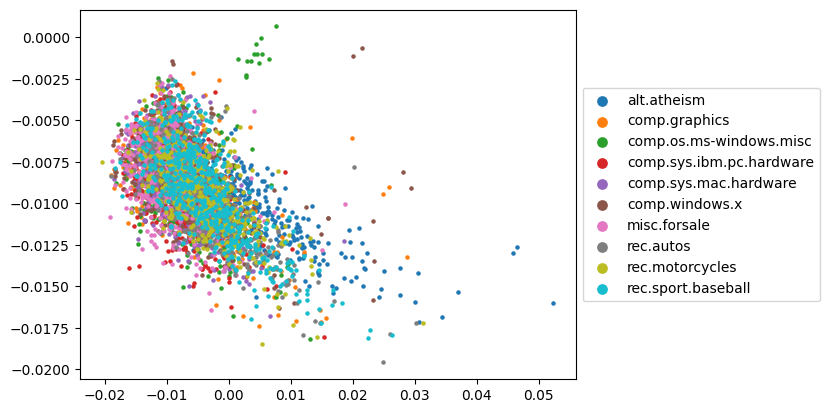

In [10]:
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=plt.cm.tab10.colors)

for i, label_name in enumerate(dataset["target_names"][:10]):
    _ix = labels == label_name
    _U = U[_ix]
    plt.scatter(_U[:, 0], _U[:, 1], s=5, label=label_name)

legend = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=3)